In [1]:
from pymoo.algorithms.moo.nsga2 import NSGA2, calc_crowding_distance, randomized_argsort
from pymoo.problems import get_problem
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from pymoo.core.survival import Survival
import numpy as np
from pymoo.util.misc import find_duplicates, has_feasible
from sklearn.decomposition import PCA

class ZDT1(Problem):

    def __init__(self, n_var=30, **kwargs):
        super().__init__(n_var=n_var, n_obj=2, n_ieq_constr=1, xl=0, xu=1, vtype=float, **kwargs)

    def _calc_pareto_front(self, n_pareto_points=100):
        x = np.linspace(0, 1, n_pareto_points)
        return np.array([x, 1 - np.sqrt(x)]).T

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[:, 0]
        g = 1 + 9.0 / (self.n_var - 1) * np.sum(x[:, 1:], axis=1)
        f2 = g * (1 - np.power((f1 / g), 0.5))

        g1 = f1 - 0.5
        g2 = f2 - 0.5
        out["F"] = np.column_stack([f1, f2])
        out["G"] = np.column_stack([g1])

class RankAndCrowdingSurvival(Survival):

    def __init__(self, nds=None, verbose=False) -> None:
        super().__init__(filter_infeasible=True)
        self.nds = nds if nds is not None else NonDominatedSorting()
        self.verbose=verbose
    def _do(self, problem, pop, *args, n_survive=None, **kwargs):

        # get the objective space values and objects
        F = pop.get("F").astype(float, copy=False)

        # the final indices of surviving individuals
        survivors = []
        # do the non-dominated sorting until splitting front
        fronts = self.nds.do(F, n_stop_if_ranked=n_survive)
        if self.verbose:
            print("Number of fronts", len(fronts))
        for k, front in enumerate(fronts):

            # calculate the crowding distance of the front
            crowding_of_front = calc_crowding_distance(F[front, :])

            # save rank and crowding in the individual class
            for j, i in enumerate(front):
                pop[i].set("rank", k)
                pop[i].set("crowding", crowding_of_front[j])

            # current front sorted by crowding distance if splitting
            if len(survivors) + len(front) > n_survive:
                I = randomized_argsort(crowding_of_front, order='descending', method='numpy')
                I = I[:(n_survive - len(survivors))]

            # otherwise take the whole front unsorted
            else:
                I = np.arange(len(front))

            # extend the survivors by all or selected individuals
            survivors.extend(front[I])

        return pop[survivors]
    
class InputOutputCrowdingSurvival(Survival):

    def __init__(self, nds=None, verbose=False) -> None:
        super().__init__(filter_infeasible=True)
        self.nds = nds if nds is not None else NonDominatedSorting()
        self.verbose=verbose
    def _do(self, problem, pop, *args, n_survive=None, **kwargs):

        # get the objective space values and objects
        F = pop.get("F").astype(float, copy=False)
        X = pop.get("X").astype(float, copy=False)  
        concat = np.concatenate((X,F), axis=-1)

        # the final indices of surviving individuals
        survivors = []

        # do the non-dominated sorting until splitting front
        fronts = self.nds.do(F, n_stop_if_ranked=n_survive)
        if self.verbose:
            print("Number of fronts (IO)", len(fronts))

        for k, front in enumerate(fronts):

            # calculate the crowding distance of the front
            crowding_of_front_input = calc_crowding_distance(F[front, :])
            crowding_of_front_output = calc_crowding_distance(X[front, :])
            crowding_of_front_concat = calc_crowding_distance(concat[front, :])
            # save rank and crowding in the individual class
            for j, i in enumerate(front):
                pop[i].set("rank", k)
                pop[i].set("crowding", crowding_of_front_concat[j])

            # current front sorted by crowding distance if splitting
            if len(survivors) + len(front) > n_survive:
                I = randomized_argsort(crowding_of_front_concat, order='descending', method='numpy')
                I = I[:(n_survive - len(survivors))]

            # otherwise take the whole front unsorted
            else:
                I = np.arange(len(front))

            # extend the survivors by all or selected individuals
            survivors.extend(front[I])

        return pop[survivors]

class InputOutputCrowdingSurvivalDimRed(Survival):

    def __init__(self, nds=None, verbose=False) -> None:
        super().__init__(filter_infeasible=True)
        self.nds = nds if nds is not None else NonDominatedSorting()
        self.verbose=verbose
    def _do(self, problem, pop, *args, n_survive=None, **kwargs):

        # get the objective space values and objects
        F = pop.get("F").astype(float, copy=False)
        X = pop.get("X").astype(float, copy=False)  
        pca = PCA(n_components=F.shape[-1])
        x_dim_red = pca.fit_transform(X)

        concat = np.concatenate((x_dim_red,F), axis=-1)

        # the final indices of surviving individuals
        survivors = []

        # do the non-dominated sorting until splitting front
        fronts = self.nds.do(F, n_stop_if_ranked=n_survive)
        if self.verbose:
            print("Number of fronts (IO)", len(fronts))

        for k, front in enumerate(fronts):

            # calculate the crowding distance of the front
            crowding_of_front_input = calc_crowding_distance(F[front, :])
            crowding_of_front_output = calc_crowding_distance(X[front, :])
            crowding_of_front_concat = calc_crowding_distance(concat[front, :])
            # save rank and crowding in the individual class
            for j, i in enumerate(front):
                pop[i].set("rank", k)
                pop[i].set("crowding", crowding_of_front_concat[j])

            # current front sorted by crowding distance if splitting
            if len(survivors) + len(front) > n_survive:
                I = randomized_argsort(crowding_of_front_concat, order='descending', method='numpy')
                I = I[:(n_survive - len(survivors))]

            # otherwise take the whole front unsorted
            else:
                I = np.arange(len(front))

            # extend the survivors by all or selected individuals
            survivors.extend(front[I])

        return pop[survivors]

class InputOutputCrowdingSurvivalDimRedAllFronts(Survival):

    def __init__(self, nds=None, verbose=False) -> None:
        super().__init__(filter_infeasible=True)
        self.nds = nds if nds is not None else NonDominatedSorting()
        self.verbose=verbose
    def _do(self, problem, pop, *args, n_survive=None, **kwargs):

        # get the objective space values and objects
        F = pop.get("F").astype(float, copy=False)
        X = pop.get("X").astype(float, copy=False)  
        pca = PCA(n_components=F.shape[-1])
        x_dim_red = pca.fit_transform(X)

        concat = np.concatenate((x_dim_red,F), axis=-1)

        # the final indices of surviving individuals
        survivors = []

        # do the non-dominated sorting until splitting front
        fronts = self.nds.do(F, n_stop_if_ranked=n_survive)
        if self.verbose:
            print("Number of fronts (IO)", len(fronts))

        for k, front in enumerate(fronts):

            # calculate the crowding distance of the front
            crowding_of_front_input = calc_crowding_distance(F[front, :])
            crowding_of_front_output = calc_crowding_distance(X[front, :])
            crowding_of_front_concat = calc_crowding_distance(concat[front, :])
            # save rank and crowding in the individual class
            for j, i in enumerate(front):
                pop[i].set("rank", k)
                pop[i].set("crowding", crowding_of_front_concat[j])

            I = randomized_argsort(crowding_of_front_concat, order='descending', method='numpy')
            I = I[:(n_survive - len(survivors))]

            # extend the survivors by all or selected individuals
            survivors.extend(front[I])

        return pop[survivors]

In [2]:
def calc_biased_crowding_distance(F, filter_out_duplicates=True, index_important=1, index_scaling=10):
    n_points, n_obj = F.shape

    if n_points <= 2:
        return np.full(n_points, np.inf)

    else:

        if filter_out_duplicates:
            # filter out solutions which are duplicates - duplicates get a zero finally
            is_unique = np.where(np.logical_not(find_duplicates(F, epsilon=1e-32)))[0]
        else:
            # set every point to be unique without checking it
            is_unique = np.arange(n_points)

        # index the unique points of the array
        _F = F[is_unique]

        # _F[:, index_important] *= index_scaling  #ADDED LINE

        # sort each column and get index
        I = np.argsort(_F, axis=0, kind='mergesort')

        # sort the objective space values for the whole matrix
        _F = _F[I, np.arange(n_obj)]

        # calculate the distance from each point to the last and next
        dist = np.row_stack([_F, np.full(n_obj, np.inf)]) - np.row_stack([np.full(n_obj, -np.inf), _F])

        # calculate the norm for each objective - set to NaN if all values are equal
        norm = np.max(_F, axis=0) - np.min(_F, axis=0)
        norm[norm == 0] = np.nan

        weights = np.ones(n_obj)
        weights[index_important] = 1/index_scaling 

        # Normalize the weights so they add up to 1
        weights = weights / np.sum(weights)
        # prepare the distance to last and next vectors
        dist_to_last, dist_to_next = dist, np.copy(dist)
        dist_to_last, dist_to_next = weights * dist_to_last[:-1] / norm, weights * dist_to_next[1:] / norm
        # if we divide by zero because all values in one columns are equal replace by none
        dist_to_last[np.isnan(dist_to_last)] = 0.0
        dist_to_next[np.isnan(dist_to_next)] = 0.0

        # sum up the distance to next and last and norm by objectives - also reorder from sorted list
        J = np.argsort(I, axis=0)
        _cd = np.sum(dist_to_last[J, np.arange(n_obj)] + dist_to_next[J, np.arange(n_obj)], axis=1) / n_obj
        # save the final vector which sets the crowding distance for duplicates to zero to be eliminated
        crowding = np.zeros(n_points)
        crowding[is_unique] = _cd

    # crowding[np.isinf(crowding)] = 1e+14
    return crowding

class WeightedRankAndCrowdingSurvival(Survival):

    def __init__(self, nds=None, index=1, scaling=0.1) -> None:
        super().__init__(filter_infeasible=True)
        self.nds = nds if nds is not None else NonDominatedSorting()
        self.index = index
        self.scaling = scaling

    def _do(self, problem, pop, *args, n_survive=None, **kwargs):

        # get the objective space values and objects
        F = pop.get("F").astype(float, copy=False)

        # the final indices of surviving individuals
        survivors = []

        # do the non-dominated sorting until splitting front
        fronts = self.nds.do(F, n_stop_if_ranked=n_survive)
        for k, front in enumerate(fronts):

            # calculate the crowding distance of the front
            crowding_of_front = calc_biased_crowding_distance(F[front, :], index_important=self.index, index_scaling=self.scaling)

            # save rank and crowding in the individual class
            for j, i in enumerate(front):
                pop[i].set("rank", k)
                pop[i].set("crowding", crowding_of_front[j])

            # current front sorted by crowding distance if splitting
            if len(survivors) + len(front) > n_survive:
                # print("Front {} of length {} is split".format(k, len(front)))
                I = randomized_argsort(crowding_of_front, order='descending', method='numpy')
                I = I[:(n_survive - len(survivors))]
                # print("Splitted has length", len(I))

            # otherwise take the whole front unsorted
            else:
                # print("Front {} of length {} is taken entirely".format(k, len(front)))
                I = np.arange(len(front))

            # extend the survivors by all or selected individuals
            survivors.extend(front[I])

        return pop[survivors]

In [3]:
from pymoo.core.callback import Callback
class KeepGenerationsCallback(Callback):
    """A pymoo Callback for printing the generation
    """

    def __init__(self) -> None:
        super().__init__()
        self.generation_instances = []

    def notify(self, algorithm, **kwargs):
        instances = [x.X[0] for x in algorithm.pop]
        objectives = np.array([x.F for x in algorithm.pop])
        self.generation_instances.append(instances)
        this_gen = algorithm.n_gen
        print("Generation {} number of instances {}".format(this_gen, len(instances)))


In [4]:
def run_algo(problem, algorithm, algorithm_args, minimize_args):
    algo = algorithm(**algorithm_args)
    res = minimize(problem,
            algo,
            **minimize_args)
    return res

from pymoo.problems.multi.omnitest import OmniTest
# problem = ZDT1(n_var=2)
# problem = get_problem("bnh")
# problem = get_problem("ctp1")
problem = OmniTest(n_var=2)
cb = KeepGenerationsCallback()

from pymoo.termination.default import DefaultMultiObjectiveTermination

termination = DefaultMultiObjectiveTermination(
    xtol=1e-8,
    cvtol=1e-6,
    ftol=0.0025,
    period=30,
    n_max_gen=100,
    n_max_evals=100000
)

# survival = WeightedRankAndCrowdingSurvival(index=0, scaling=10)
# survival = InputOutputCrowdingSurvival()
algorithm = NSGA2
algorithm_normal_arguments = {"survival":RankAndCrowdingSurvival(), "pop_size":100, "callback":cb}
algorithm_io_arguments = {"survival":InputOutputCrowdingSurvival(), "pop_size":100, "callback":cb}

minimize_args = {"seed":1, "verbose":False, "termination":termination}
res_no_surv = run_algo(problem, algorithm, algorithm_normal_arguments, minimize_args)
res_IO = run_algo(problem, algorithm, algorithm_io_arguments, minimize_args)

results = [res_no_surv, res_IO]

Generation 1 number of instances 100
Generation 2 number of instances 100
Generation 3 number of instances 100
Generation 4 number of instances 100
Generation 5 number of instances 100
Generation 6 number of instances 100
Generation 7 number of instances 100
Generation 8 number of instances 100
Generation 9 number of instances 100
Generation 10 number of instances 100
Generation 11 number of instances 100
Generation 12 number of instances 100
Generation 13 number of instances 100
Generation 14 number of instances 100
Generation 15 number of instances 100
Generation 16 number of instances 100
Generation 17 number of instances 100
Generation 18 number of instances 100
Generation 19 number of instances 100
Generation 20 number of instances 100
Generation 21 number of instances 100
Generation 22 number of instances 100
Generation 23 number of instances 100
Generation 24 number of instances 100
Generation 25 number of instances 100
Generation 26 number of instances 100
Generation 27 number 

/home/luser/Kallikrates/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/luser/Kallikrates/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/luser/Kallikrates/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/luser/Kallikrates/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

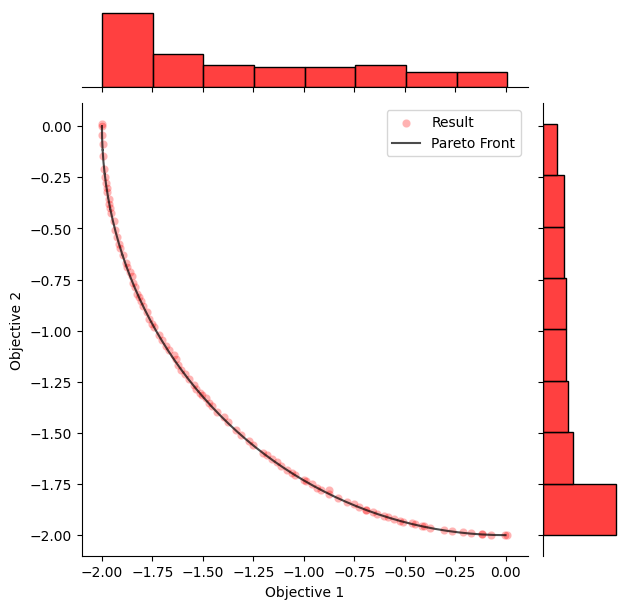

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming problem.pareto_front() and res.F are numpy arrays
pareto_front = problem.pareto_front()
F = res_no_surv.F

# Create a jointplot
g = sns.jointplot(data=None, x=F[:, 0], y=F[:, 1], kind='scatter', color='red', alpha=0.3, label='Result')

p = plt.plot(pareto_front[:, 0], pareto_front[:, 1], label='Pareto Front', color='black', alpha=0.7)


# Set labels
g.set_axis_labels('Objective 1', 'Objective 2')

# Add legend
g.ax_joint.legend()

# Show the plot
plt.show()

In [6]:
import pandas as pd

labels = ["Crowding Distance on Objectives (normal)", "Crowding Distance on Objectives and Variables (ours)"]
dfFs = []
dfXs = []
for res, label in zip(results, labels):
    dfF = pd.DataFrame(res.F, columns=["Objective 1", "Objective 2"])
    dfX = pd.DataFrame(res.X, columns=["Variable 0", "Variable 1"])
    dfF["label"] = label
    dfX["label"] = label
    dfFs.append(dfF)
    dfXs.append(dfX)
dfF_concat = pd.concat(dfFs)
dfX_concat = pd.concat(dfXs)

In [7]:
from matplotlib.lines import Line2D

def plot_objective_space(problem, dfFs, dfF_concat, alpha = 0.5, bw_adjust = 0.2, kind="kde"):

    palt = sns.color_palette()
    axs = sns.jointplot(x="Objective 1", y="Objective 2", data=dfFs[0], alpha=alpha, color=palt[0], edgecolor="k")
    axs.ax_joint.scatter("Objective 1", "Objective 2", data=dfFs[1], alpha=alpha, color=palt[1], edgecolor="k")
    # drawing pdf instead of histograms on the marginal axes
    axs.ax_marg_x.cla()
    axs.ax_marg_y.cla()
    if kind=="hist":
        s1 = sns.histplot(dfF_concat, x="Objective 1", ax=axs.ax_marg_x, hue="label", palette=palt)
        s2 = sns.histplot(dfF_concat, y="Objective 2", ax=axs.ax_marg_y, hue="label", palette=palt)
    else:
        s1 = sns.kdeplot(dfF_concat, x="Objective 1", ax=axs.ax_marg_x, hue="label", palette=palt, cut=0, fill=True, bw_adjust=bw_adjust)
        s2 = sns.kdeplot(dfF_concat, y="Objective 2", ax=axs.ax_marg_y, hue="label", palette=palt, cut=0, fill=True, bw_adjust=bw_adjust)
    s1.set(xlabel="", ylabel="")
    s2.set(xlabel="", ylabel="")
    s1.legend([],[], frameon=False)
    s2.legend([],[], frameon=False)
    legend_elements = []
    try:
        pareto_front = problem.pareto_front()
        p = plt.plot(pareto_front[:, 0], pareto_front[:, 1], label='Pareto Front', color='black', alpha=0.7)

        legend_elements = [Line2D([0], [0], color='black', lw=2, label='Pareto Front')]
    except:
        pass

    for pal, name in zip(palt, labels) :
        legend_elements.append(Line2D([0], [0], marker="o", color='w', markerfacecolor=pal, markersize=10, label=name, markeredgecolor="k", alpha=alpha))

    plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True)
    axs.fig.suptitle("Objective space")

def plot_design_space(dfXs, dfX_concat, alpha = 0.5, bw_adjust = 0.2, kind="kde"):

    palt = sns.color_palette()
    axs = sns.jointplot(x="Variable 0", y="Variable 1", data=dfXs[0], alpha=alpha, marginal_kws={"bins": "sqrt"})
    axs.ax_joint.scatter(x="Variable 0", y="Variable 1", data=dfXs[1], alpha=alpha, color=palt[1])

    # drawing pdf instead of histograms on the marginal axes
    axs.ax_marg_x.cla()
    axs.ax_marg_y.cla()
    if kind=="hist":
        s1 = sns.histplot(dfX_concat, x="Variable 0", ax=axs.ax_marg_x, hue="label", palette=palt)
        s2 = sns.histplot(dfX_concat, y="Variable 1", ax=axs.ax_marg_y, hue="label", palette=palt)
    else:
        s1 = sns.kdeplot(dfX_concat, x="Variable 0", ax=axs.ax_marg_x, hue="label", palette=palt, cut=0, fill=True, bw_adjust=bw_adjust)
        s2 = sns.kdeplot(dfX_concat, y="Variable 1", ax=axs.ax_marg_y, hue="label", palette=palt, cut=0, fill=True, bw_adjust=bw_adjust)
    s1.set(xlabel="", ylabel="")
    s2.set(xlabel="", ylabel="")
    s1.legend([],[], frameon=False)
    s2.legend([],[], frameon=False)
    legend_elements = []

    for pal, name in zip(palt, labels) :
        legend_elements.append(Line2D([0], [0], marker="o", color='w', markerfacecolor=pal, markersize=10, label=name, markeredgecolor="k", alpha=alpha))
    plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True)
    axs.fig.suptitle("Design (solution) space")

/home/luser/Kallikrates/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/luser/Kallikrates/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/luser/Kallikrates/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/luser/Kallikrates/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

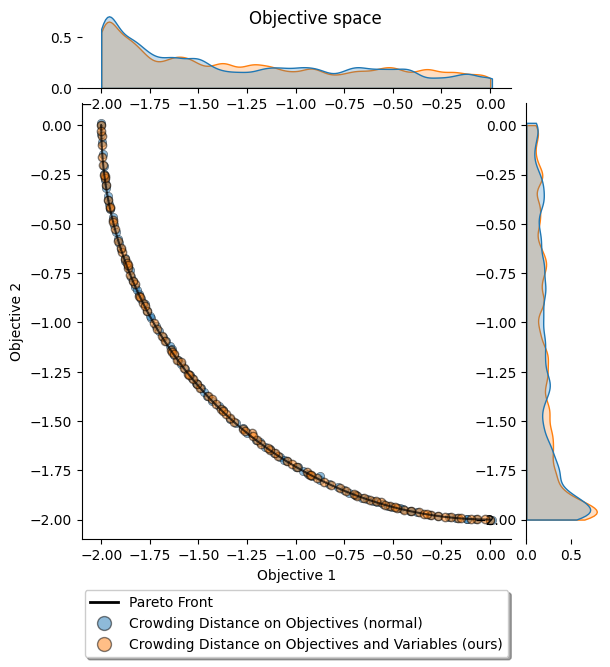

In [8]:
plot_objective_space(problem, dfFs, dfF_concat)

/home/luser/Kallikrates/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/luser/Kallikrates/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/luser/Kallikrates/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/luser/Kallikrates/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

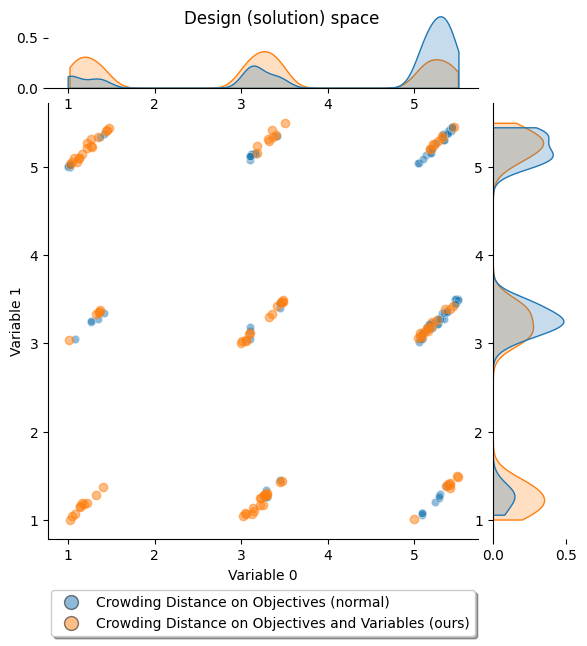

In [9]:
plot_design_space(dfXs, dfX_concat)

In [10]:
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.util.ref_dirs import get_reference_directions

algorithm = MOEAD
ref_dirs = get_reference_directions("uniform", 2, n_partitions=12)
moaed_normal_arguments = {"ref_dirs":ref_dirs, "n_neighbors":15, "prob_neighbor_mating":0.7, }
# moaed_normal_arguments = {"ref_dirs":ref_dirs, "n_neighbors":15, "prob_neighbor_mating":0.7, "survival":RankAndCrowdingSurvival(), "pop_size":100, "callback":cb}

res_no_surv = run_algo(problem, algorithm, moaed_normal_arguments, minimize_args)
# res_IO = run_algo(problem, algorithm, algorithm_io_arguments, minimize_args)

# results = [res_no_surv, res_IO]

In [11]:
from sklearn.neighbors import KernelDensity

def mean_density(instances):
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(instances)

    density = np.exp(kde.score_samples(instances))
    return np.mean(density)
def std_density(instances):
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(instances)

    density = np.exp(kde.score_samples(instances))
    return np.std(density)
def coefficient_of_variation(data):
        mean = np.mean(data)
        std_dev = np.std(data)

        return std_dev / mean
def cv_density(instances):
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(instances)
    density = np.exp(kde.score_samples(instances))

    cv = coefficient_of_variation(density)
    return cv


In [12]:
from scipy.stats import entropy
from npeet import entropy_estimators as ee
from tabulate import tabulate
# "Entropy (scipy)": entropy, 
metrics = {"Entropy (scipy)": entropy, "Differencial entropy (npeet)": ee.entropy, "Discrete entropy (npeet)": ee.entropyd, "std": np.std, "var": np.var, "Mean Density": mean_density, "std Density":std_density, "Coefficient of Variation (std/mean) of density": cv_density}
# Initialize an empty table

def format_value(value):
    if isinstance(value, float):
        return f'{value:.2f}'
    else:
        return '[' + ', '.join(f'{v:.2f}' for v in value) + ']'


def get_metrics(metrics, instances):   
    table = {}
    # Populate the table with metric values
    for metric_name, metric in metrics.items():
        table[metric_name] = format_value(metric(instances))
    return table

def get_pretty_table(metrics_list, labels):
    # Get the field names (header) from the first dictionary
    field_names = list(metrics_list[0].keys())
    table_data = []
    for field_name in field_names:
        row = [field_name]
        for mdict in metrics_list:
            row.append(mdict[field_name])
        table_data.append(row)
    print(tabulate(table_data, headers=labels, tablefmt='pretty'))

metrics_list = [get_metrics(metrics, res.X) for res in results]

get_pretty_table(metrics_list, labels)

+------------------------------------------------+------------------------------------------+------------------------------------------------------+
|                                                | Crowding Distance on Objectives (normal) | Crowding Distance on Objectives and Variables (ours) |
+------------------------------------------------+------------------------------------------+------------------------------------------------------+
|                Entropy (scipy)                 |               [4.53, 4.54]               |                     [4.47, 4.46]                     |
|          Differencial entropy (npeet)          |                  -1.32                   |                        -0.58                         |
|            Discrete entropy (npeet)            |                   6.64                   |                         6.64                         |
|                      std                       |                   1.43                   |             

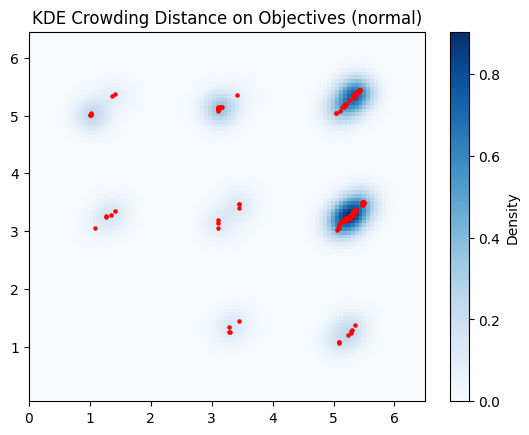

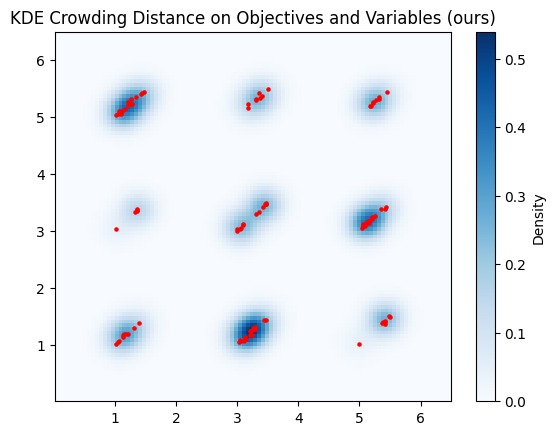

In [13]:
def plot_kde(points, kde, label):
    x_min, x_max = np.min(points[:, 0]) - 1, np.max(points[:, 0]) + 1
    y_min, y_max = np.min(points[:, 1]) - 1, np.max(points[:, 1]) + 1

    x, y = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid_points = np.c_[x.ravel(), y.ravel()]

    density = np.exp(kde.score_samples(grid_points))
    density = density.reshape(x.shape)

    plt.imshow(density, cmap='Blues', extent=(x_min, x_max, y_min, y_max), origin='lower', aspect='auto')
    plt.colorbar(label='Density')
    plt.scatter(points[:, 0], points[:, 1], c='red', s=5)
    plt.title('KDE ' + label)
    plt.show()
    
for res, label in zip(results, labels):
    instances = res.X
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(instances)

    plot_kde(instances, kde, label)


In [14]:
def sample_uniform_2d(min_x, min_y, max_x, max_y, num_samples):
    # Generate random numbers in the range [0, 1]
    random_x = np.random.rand(num_samples)
    random_y = np.random.rand(num_samples)
    
    # Scale and shift to fit within the desired range
    x = min_x + random_x * (max_x - min_x)
    y = min_y + random_y * (max_y - min_y)
    
    return np.array([(x[i], y[i]) for i in range(num_samples)])

def create_2d_grid(min_x, min_y, max_x, max_y, max_instances):
    # Calculate the number of points in each dimension
    num_x = int(np.sqrt(max_instances * ((max_x - min_x) / (max_y - min_y))))
    num_y = int((max_instances / num_x))

    # Generate the grid
    x = np.linspace(min_x, max_x, num_x)
    y = np.linspace(min_y, max_y, num_y)
    xx, yy = np.meshgrid(x, y)

    points = np.vstack([xx.ravel(), yy.ravel()]).T

    return points

number_of_samples = 100
min_all = dfX_concat.min().to_list()
max_all = dfX_concat.max().to_list()
unifrom_samples = sample_uniform_2d(min_all[0], min_all[1], max_all[0], max_all[1], number_of_samples)
constant_samples = np.zeros((number_of_samples, 2))
grid_samples = create_2d_grid(min_all[0], min_all[1], max_all[0], max_all[1], number_of_samples)


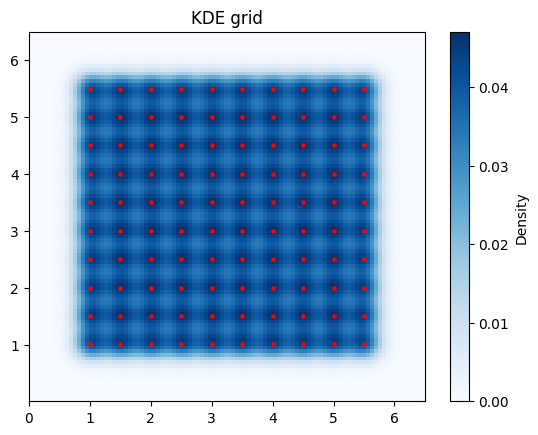

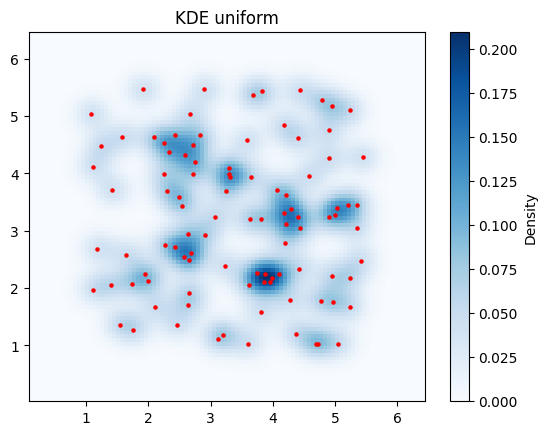

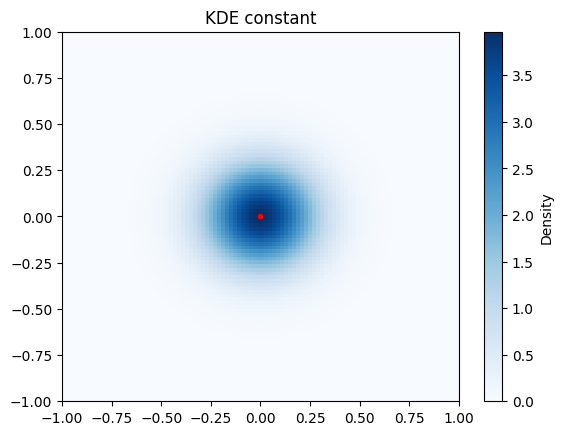

+------------------------------------------------+--------------+--------------+------------+
|                                                |     grid     |   uniform    |  constant  |
+------------------------------------------------+--------------+--------------+------------+
|                Entropy (scipy)                 | [4.50, 4.50] | [4.54, 4.52] | [nan, nan] |
|          Differencial entropy (npeet)          |     5.31     |     4.54     |   -66.05   |
|            Discrete entropy (npeet)            |     6.64     |     6.64     |    0.00    |
|                      std                       |     1.44     |     1.25     |    0.00    |
|                      var                       |     2.07     |     1.56     |    0.00    |
|                  Mean Density                  |     0.05     |     0.09     |    3.98    |
|                  std Density                   |     0.00     |     0.04     |    0.00    |
| Coefficient of Variation (std/mean) of density |     0.02 

/home/luser/Kallikrates/venv/lib/python3.10/site-packages/scipy/stats/_entropy.py:133: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


In [15]:
tests = [grid_samples, unifrom_samples, constant_samples]
labels_test = ["grid", "uniform", "constant"]

metrics_list_tests = []
for instances, label in zip(tests, labels_test):
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(instances)

    plot_kde(instances, kde, label)
    metrics_list_tests.append(get_metrics(metrics, instances))

get_pretty_table(metrics_list_tests, labels_test)
get_pretty_table(metrics_list + metrics_list_tests, labels + labels_test)

In [16]:
from pymoo.problems.multi.omnitest import OmniTest
# problem = ZDT1(n_var=2)
# problem = get_problem("bnh")
# problem = get_problem("ctp1")
problem_high = OmniTest(n_var=100)


res_no_surv_high = run_algo(problem_high, algorithm, algorithm_normal_arguments, minimize_args)
res_IO_high = run_algo(problem_high, algorithm, algorithm_io_arguments, minimize_args)

results_high = [res_no_surv_high, res_IO_high]

TypeError: object of type 'NoneType' has no len()

In [17]:
import pandas as pd

dfFs_high = []
dfXs_high = []
for res, label in zip(results_high, labels):
    dfF = pd.DataFrame(res.F, columns=["Objective 1", "Objective 2"])
    dfX = pd.DataFrame(res.X)
    dfF["label"] = label
    dfFs_high.append(dfF)
    dfXs_high.append(dfX)
dfF_concat_high = pd.concat(dfFs_high)
dfX_concat_high = pd.concat(dfXs_high)

NameError: name 'results_high' is not defined

In [ ]:
plot_objective_space(problem_high, dfFs_high, dfF_concat_high)


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
inp = dfX_concat_high
pca.fit(inp)
individual_pca_eigens = []
transXs = []
for dfXh, label in zip(dfXs_high, labels):
    individual_pca_eigens.append(PCA(n_components=2).fit(dfXh).explained_variance_)

    trans_x = pd.DataFrame(pca.transform(dfXh), columns=["Variable 0", "Variable 1"])
    trans_x["label"] = label
    transXs.append(trans_x)

trans_x_concat = pd.concat(transXs)

In [ ]:
plot_design_space(transXs, trans_x_concat)

In [ ]:
eigenvalues_g = pca.explained_variance_
print("Global PCA det(C)=", np.prod(eigenvalues_g))
for eigenvalues, label in zip(individual_pca_eigens, labels):
    print("{} PCA det(C)={}".format(label, np.prod(eigenvalues)))

In [ ]:
from pymoo.problems.multi.omnitest import OmniTest
# problem = ZDT1(n_var=2)
# problem = get_problem("bnh")
# problem = get_problem("ctp1")
problem_high = OmniTest(n_var=100)


# survival = WeightedRankAndCrowdingSurvival(index=0, scaling=10)
# survival = InputOutputCrowdingSurvival()
res_no_surv_high_dim_red = run_algo(problem_high, survival=RankAndCrowdingSurvival(), pop_size=100, termination=termination)
res_IO_high_dim_red = run_algo(problem_high, survival=InputOutputCrowdingSurvivalDimRed(verbose=True), pop_size=100, termination=termination)

results_high_dim_red = [res_no_surv_high_dim_red, res_IO_high_dim_red]



In [ ]:
dfFs_high_dim_red = []
dfXs_high_dim_red = []
for res, label in zip(results_high_dim_red, labels):
    dfF = pd.DataFrame(res.F, columns=["Objective 1", "Objective 2"])
    dfX = pd.DataFrame(res.X)
    dfF["label"] = label
    dfFs_high_dim_red.append(dfF)
    dfXs_high_dim_red.append(dfX)
dfF_concat_high_dim_red = pd.concat(dfFs_high_dim_red)
dfX_concat_high_dim_red = pd.concat(dfXs_high_dim_red)

In [ ]:
plot_objective_space(problem_high, dfFs_high_dim_red, dfXs_high_dim_red)


In [ ]:
pca = PCA(n_components=2)
inp = dfX_concat_high_dim_red
pca.fit(inp)
individual_pca_eigens = []
transXs_dim_red = []
for dfXh, label in zip(dfXs_high_dim_red, labels):
    individual_pca_eigens.append(PCA(n_components=2).fit(dfXh).explained_variance_)

    trans_x = pd.DataFrame(pca.transform(dfXh), columns=["Variable 0", "Variable 1"])
    trans_x["label"] = label
    transXs_dim_red.append(trans_x)

trans_x_concat_dim_red = pd.concat(transXs_dim_red)

In [ ]:
plot_design_space(transXs_dim_red, trans_x_concat_dim_red)


In [ ]:
from pymoo.problems.multi.omnitest import OmniTest
# problem = ZDT1(n_var=2)
# problem = get_problem("bnh")
# problem = get_problem("ctp1")
problem_high = OmniTest(n_var=100)


# survival = WeightedRankAndCrowdingSurvival(index=0, scaling=10)
# survival = InputOutputCrowdingSurvival()
res_no_surv_high_dim_red_all = run_algo(problem_high, survival=RankAndCrowdingSurvival(), pop_size=100, termination=termination)
res_IO_high_dim_red_all = run_algo(problem_high, survival=InputOutputCrowdingSurvivalDimRedAllFronts(verbose=True), pop_size=100, termination=termination)

results_high_dim_red_all = [res_no_surv_high_dim_red_all, res_IO_high_dim_red_all]



In [ ]:
dfFs_high_dim_red_all = []
dfXs_high_dim_red_all = []
for res, label in zip(results_high_dim_red_all, labels):
    dfF = pd.DataFrame(res.F, columns=["Objective 1", "Objective 2"])
    dfX = pd.DataFrame(res.X)
    dfF["label"] = label
    dfFs_high_dim_red_all.append(dfF)
    dfXs_high_dim_red_all.append(dfX)
dfF_concat_high_dim_red_all = pd.concat(dfFs_high_dim_red_all)
dfX_concat_high_dim_red_all = pd.concat(dfXs_high_dim_red_all)

In [ ]:
plot_objective_space(problem_high, dfFs_high_dim_red_all, dfXs_high_dim_red_all)

In [ ]:
pca = PCA(n_components=2)
inp = dfX_concat_high_dim_red_all
pca.fit(inp)
individual_pca_eigens = []
transXs_dim_red_all = []
for dfXh, label in zip(dfXs_high_dim_red_all, labels):
    individual_pca_eigens.append(PCA(n_components=2).fit(dfXh).explained_variance_)

    trans_x = pd.DataFrame(pca.transform(dfXh), columns=["Variable 0", "Variable 1"])
    trans_x["label"] = label
    transXs_dim_red_all.append(trans_x)

trans_x_concat_dim_red_all = pd.concat(transXs_dim_red_all)

In [ ]:
plot_design_space(transXs_dim_red_all, trans_x_concat_dim_red_all)
